# DMT
Mazeworld with discrete morse theory

In [1]:
import sys

sys.path.append("../src")

from environments import MazeEnv
from policies import BaseAgent, QLearningAgent
from dmt import environment_to_graph, classify_simplices, visualize_graph

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

from tqdm import tqdm
from copy import deepcopy

In [2]:
env = MazeEnv()
agent = BaseAgent(env, gamma=0.999)
agent.value_iteration(threshold=1e-8, max_iterations=100000)
optimal_value_function = agent.value_function

In [3]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=0.999, alpha=0.01)
agent.compute_optimal_q_function(threshold=1e-8, max_iterations=100000)
optimal_q_function = agent.q_table

Optimal Q-function computed.


In [4]:
# check if max_a q_{opt}(s, a) == v_{opt{(s)
np.allclose(np.max(optimal_q_function, axis=-1), optimal_value_function, rtol=1e-5, atol=1e-5)

True

# Env to graph
Convert a gymnasium environment to a graph. 

We connect states $s$ and $s'$ with an edge if an action at $s$ can take us to $s'$. For now we assume the graph is undirected. So we make no distinction between edge $s\rightarrow s'$ and $s' \rightarrow s$.

We make a few assumptions about this conversion. First we assign a real-valued function on the verticies as determined by the value function. 

For the edge $(s, s')$ we consider the two values $q(s, a)$ and $q(s', a')$ where $a$ and $a'$ are the actions that take us from $s$ to $s'$ and $s'$ to $s$ respectively. We then assign the edge a value of the max of the two.

In general, the optimal $q$ function seems to always satisfy the requirements of a morse function. 

But during _learning_ of an approximate $q$ function there are very often cycles, especially in under-explored regions of the maze (basically the agent flips back and forth between two nodes).

The current approach is just a starting point. Ideally we want to incorporate the entire structure of the MDP including the probability simplex over actions at each state.

In [5]:
G = environment_to_graph(env, optimal_q_function)

In [6]:
list(G.nodes(data=True))[:5]

[(0, {'node_value': -25.67668060985113}),
 (12, {'node_value': -24.701382001818747}),
 (1, {'node_value': -26.651002929241276}),
 (2, {'node_value': -27.624349926312036}),
 (3, {'node_value': -26.651266057544625})]

In [7]:
list(G.edges(data=True))[:5]

[(0, 12, {'edge_value': -25.67668060985113}),
 (0, 1, {'edge_value': -26.651002929241276}),
 (12, 14, {'edge_value': -24.701382001818747}),
 (1, 2, {'edge_value': -27.624349926312036}),
 (2, 3, {'edge_value': -27.6246127815412})]

# Basic Morse theory

Compute all critical/regular nodes/edges.



In [8]:
# Run the classification function
(
    critical_nodes,
    regular_nodes,
    critical_edges,
    regular_edges,
) = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_edges is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")


Discrete Morse function found
Critical Nodes: [(67, {'node_value': 0})]
Regular Nodes: [(0, {'node_value': -25.67668060985113}), (12, {'node_value': -24.701382001818747}), (1, {'node_value': -26.651002929241276}), (2, {'node_value': -27.624349926312036}), (3, {'node_value': -26.651266057544625}), (4, {'node_value': -25.67694601350402}), (5, {'node_value': -24.70165167512502}), (6, {'node_value': -23.72538206713805}), (7, {'node_value': -22.748136213297236}), (8, {'node_value': -21.769913136379493}), (9, {'node_value': -20.79071185818357}), (10, {'node_value': -19.81053139952898}), (11, {'node_value': -18.829370780255115}), (13, {'node_value': -17.847229019220222}), (14, {'node_value': -23.72511913091548}), (15, {'node_value': -16.86410613530141}), (16, {'node_value': -22.747881021903186}), (17, {'node_value': -15.880001146393683}), (18, {'node_value': -21.76966669856756}), (26, {'node_value': -14.894913069408979}), (27, {'node_value': -20.79047518371709}), (19, {'node_value': -13.90885

# Visualization

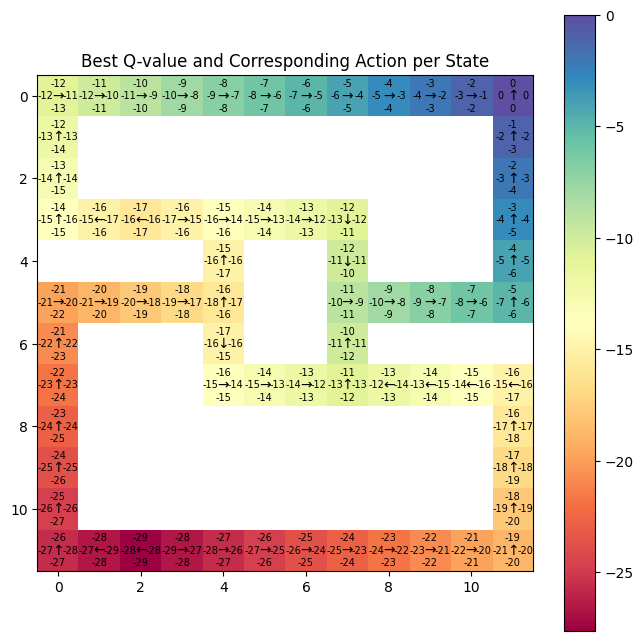

In [9]:
agent.plot_best_action_q_values()

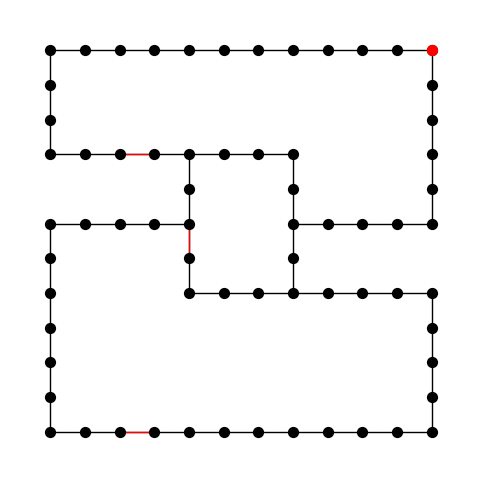

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [10]:
visualize_graph(G, env, critical_nodes, critical_edges)

In [11]:
from dmt import get_induced_gradient_vector_field, visualize_induced_vector_field

V = get_induced_gradient_vector_field(G)

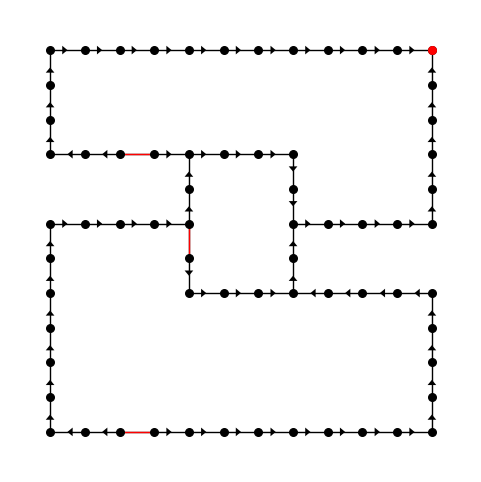

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [12]:
visualize_induced_vector_field(G, env, critical_nodes, critical_edges, V)

Optimal policy is given by the gradient paths. The critical node is the goal (terminal) state.

The critical edges are the points where you can move in either direction to get to the goal with the same total reward. The critical edges are not necessarily "decision points" in navigation.

# Homology

Assume $\mathbb{R}$ coefficients.

In [13]:
from dmt import boundary_operator_r, betti_numbers

<Axes: >

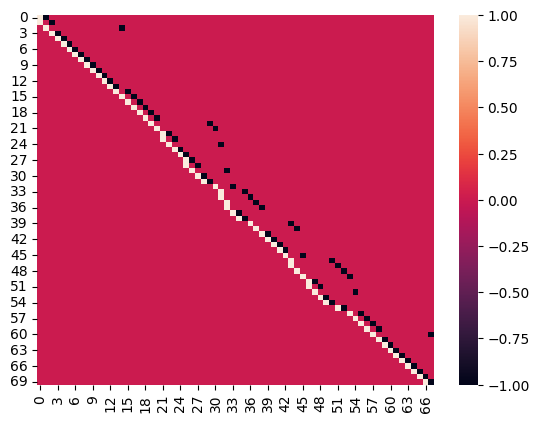

In [14]:
D = boundary_operator_r(G)
sns.heatmap(D)

In [15]:
def betti_numbers(G):
    D = boundary_operator_r(G)
    rank = np.linalg.matrix_rank(D)
    b_0 = D.shape[1] - rank
    b_1 = D.shape[0] - rank
    return b_0, b_1

In [16]:
b0, b1 = betti_numbers(G)

Theorem 2.xx tells us that the Euler characteristic $\chi = m_0 - m_1$. Let's confirm.

In [17]:
m0 = len(critical_nodes)
m1 = len(critical_edges)
chi = m0 - m1
print(chi)

-2


In [18]:
def euler_characteristic(G):
    V = G.number_of_nodes()
    E = G.number_of_edges()
    return V - E

In [19]:
euler_characteristic(G)

-2

# Homological sequences

For each critical value, compute the Betti numbers of the subcomplex of the graph.

Assumes the graph case for now.

In [20]:
def subcomplex(G, c):
    # Get the nodes whose Morse function value is less than or equal to c
    nodes = [node[0] for node in G.nodes(data=True) if -node[1]["node_value"] <= c]
    # Get the edges whose Morse function value is less than or equal to c
    edges = [edge[:2] for edge in G.edges(data=True) if -edge[2]["edge_value"] <= c]
    # Return the subgraph of G induced by these nodes and edges
    return G.edge_subgraph(edges).subgraph(nodes)

In [21]:
critical_values = [-v[-1]['node_value'] for v in critical_nodes] + [-e[-1]['edge_value'] for e in critical_edges]
critical_values = sorted(set(critical_values))

In [22]:
for c in critical_values:
    try:
        print(
            f"{betti_numbers(subcomplex(G, c))},\t {c:.02f})")
    except:
        pass

(1, 1),	 15.88)
(1, 2),	 15.88)
(1, 3),	 27.62)


# Trained agent
Now let's do morse stuff on a learned Q function (over the course of training) instead of a pre-computed optimal Q function.

In [23]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=1, alpha=0.1)
agent.compute_optimal_q_function()
optimal_q_function = agent.q_table

Optimal Q-function computed.


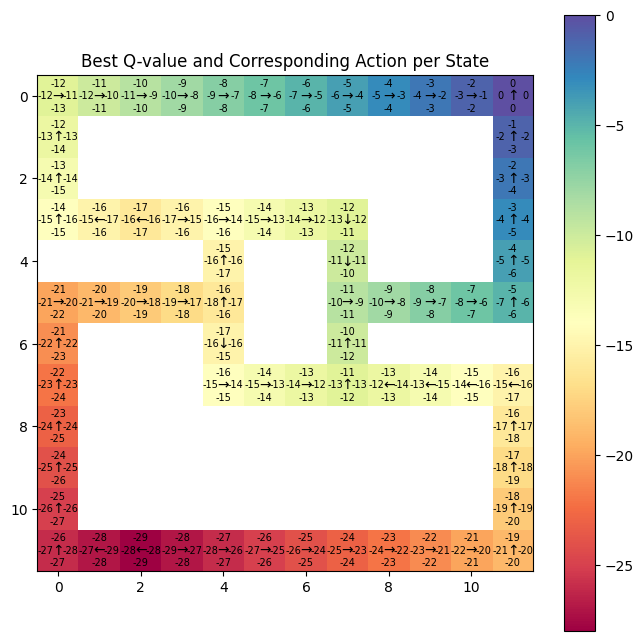

In [24]:
agent.plot_best_action_q_values()

In [25]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=1.0, alpha=0.03, epsilon_decay=0.99)
agent.train_with_summary(episodes=100, max_steps_per_episode=10000)
trained_q_function = agent.q_table

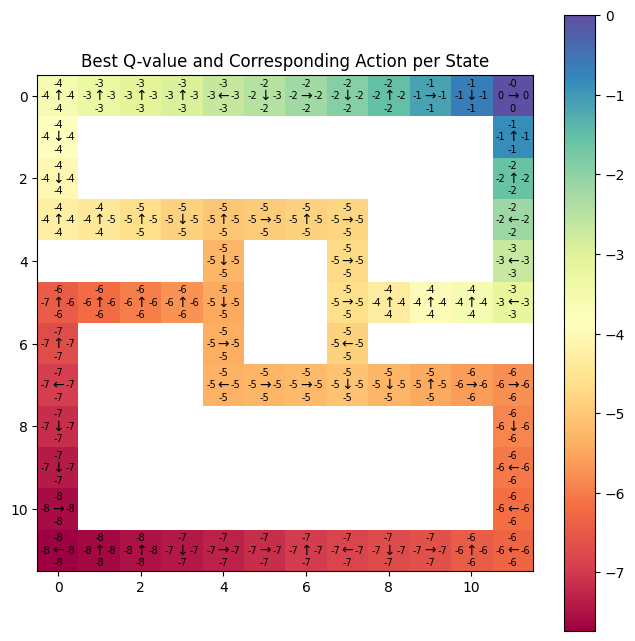

In [26]:
agent.plot_best_action_q_values()

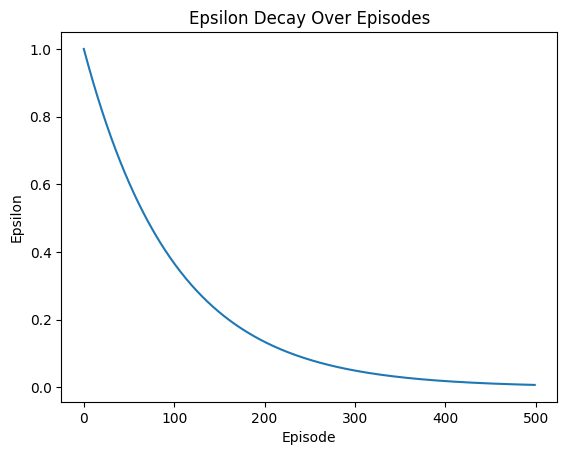

In [27]:
agent.plot_epsilon(500)

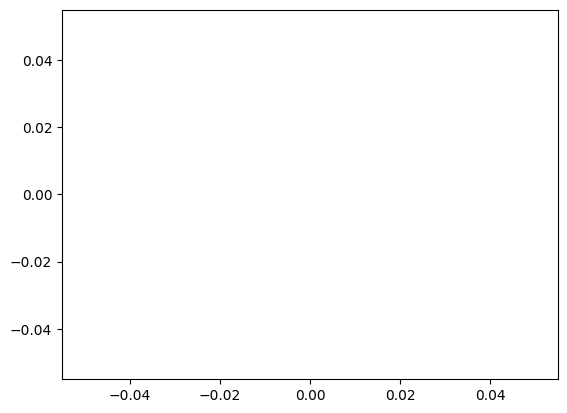

In [28]:
plt.plot([agent.summary[i]["m0"] for i in range(len(agent.summary))])
plt.plot([agent.summary[i]["m1"] for i in range(len(agent.summary))])

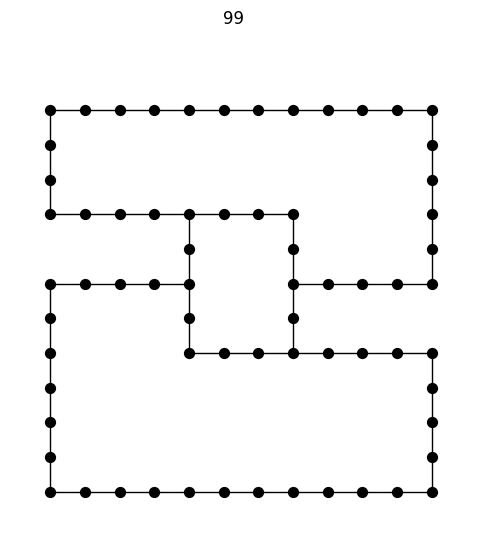

In [29]:
import IPython.display as display

fig, ax = plt.subplots(figsize=(6, 6))

for i in range(len(agent.summary)):
    fig.suptitle(f"{i}")

    data = agent.summary[i]
    if data["critical_nodes"] is None:
        fig, ax = visualize_graph(data["G"], env, [], [], figax=(fig, ax))
    else:
        fig, ax = visualize_induced_vector_field(
            data["G"],
            env,
            data["critical_nodes"],
            data["critical_edges"],
            data["induced_vector_field"],
            figax=(fig, ax),
        )
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1)
    ax.clear()

In [30]:
# when planning:
# with optimal q: a critical node iff it's an exit state
# so during training, auxiliary goal is...
# - to identify critical nodes that are not exit states? collapse them?
# - or some other strategy? e.g. 
# point is to find some aux planning strategy to best update q fn based on morse structure
# warning: always compare to other search, depth-first etc
# because beating q learning is not hard in simple environments like this

In [31]:
G = agent.summary[4]["G"]
q = agent.summary[4]["q"]

In [32]:
critical_nodes = []
regular_nodes = []
critical_edges = []
regular_edges = []

# Function to classify nodes
for node in G.nodes(data=True):
    node_value = -node[1]["node_value"]  # take negative of value fn to get morse fn
    edges = G.edges(node[0], data=True)
    exception_count = sum(
        -edge_data["edge_value"] <= node_value for _, _, edge_data in edges
    )  # take negative of edge value to get morse fn

    if exception_count == 0:
        critical_nodes.append(node)
    elif exception_count == 1:
        regular_nodes.append(node)
    else:
        print(node, node_value, edges, exception_count)

# Function to classify edges
for edge in G.edges(data=True):
    edge_value = -edge[2]["edge_value"]
    faces = [edge[0], edge[1]]
    exception_count = sum(-G.nodes[face]["node_value"] >= edge_value for face in faces)

    if exception_count == 0:
        critical_edges.append(edge)
    elif exception_count == 1:
        regular_edges.append(edge)
    else:
        print(
            edge,
            edge_value,
            exception_count,
            faces,
            [-G.nodes[face]["node_value"] for face in faces]
        )

(6, {'node_value': -1.2789147052199992}) 1.2789147052199992 [(6, 5, {'edge_value': -1.2706830347545284}), (6, 7, {'edge_value': -1.2789147052199992})] 2
(8, {'node_value': -1.089126430164037}) 1.089126430164037 [(8, 7, {'edge_value': -1.0610386759506472}), (8, 9, {'edge_value': -1.089126430164037})] 2
(16, {'node_value': -1.1314028666401537}) 1.1314028666401537 [(16, 14, {'edge_value': -1.1314028666401537}), (16, 18, {'edge_value': -0.9601247635705457})] 2
(28, {'node_value': -0.9177863554470619}) 0.9177863554470619 [(28, 19, {'edge_value': -0.8418345051254386}), (28, 34, {'edge_value': -0.9177863554470619})] 2
(39, {'node_value': -0.28586619749886555}) 0.28586619749886555 [(39, 38, {'edge_value': -0.28586619749886555}), (39, 42, {'edge_value': -0.22839965040978516})] 2
(42, {'node_value': -0.22839965040978516}) 0.22839965040978516 [(42, 39, {'edge_value': -0.22839965040978516}), (42, 51, {'edge_value': -0.22444760246794382})] 2
(46, {'node_value': -0.5152535419132835}) 0.5152535419132

In [33]:
# simulate agent, detect self-loops
q_table = agent.summary[4]["q"]
states = env._state_to_grid.keys()
state_sequence = {}
for s in tqdm(states):
    print(s)
    env.reset()
    env._agent_state = s
    state_list = [s]
    cur_state = s
    while True:
        actions = []
        for a in range(env.action_space.n):
            next_state, _ = env.get_next_state_and_reward(cur_state, a)
            if next_state == cur_state:
                q_table[cur_state][a] = -np.inf
        action = q_table[cur_state].argmax()
        ns, r = env.get_next_state_and_reward(cur_state, action)
        if ns in env.terminal_states:
            print("terminal", state_list)
            break
        state_list.append(ns)
        if ns in state_list[:-1]:
            print("repetition", state_list)
            break
        cur_state = deepcopy(ns)
    
    state_sequence[s] = state_list

100%|██████████| 68/68 [00:00<00:00, 11527.47it/s]

0
repetition [0, 1, 0]
1
repetition [1, 0, 1]
2
repetition [2, 1, 0, 1]
3
repetition [3, 4, 5, 6, 7, 8, 9, 10, 11, 10]
4
repetition [4, 5, 6, 7, 8, 9, 10, 11, 10]
5
repetition [5, 6, 7, 8, 9, 10, 11, 10]
6
repetition [6, 7, 8, 9, 10, 11, 10]
7
repetition [7, 8, 9, 10, 11, 10]
8
repetition [8, 9, 10, 11, 10]
9
repetition [9, 10, 11, 10]
10
repetition [10, 11, 10]
11
repetition [11, 10, 11]
12
repetition [12, 14, 16, 14]
13
repetition [13, 15, 17, 26, 17]
14
repetition [14, 16, 14]
15
repetition [15, 17, 26, 17]
16
repetition [16, 14, 16]
17
repetition [17, 26, 17]
18
repetition [18, 16, 14, 16]
19
repetition [19, 20, 19]
20
repetition [20, 19, 20]
21
repetition [21, 20, 19, 20]
22
repetition [22, 23, 24, 23]
23
repetition [23, 24, 23]
24
repetition [24, 23, 24]
25
repetition [25, 26, 17, 26]
26
repetition [26, 17, 26]
27
repetition [27, 18, 16, 14, 16]
28
repetition [28, 34, 40, 47, 46, 45, 44, 43, 52, 43]
29
repetition [29, 22, 23, 24, 23]
30
repetition [30, 27, 18, 16, 14, 16]
31
repe